# Example Preprocessing Flow
- Calculate the target as % change between sucessive raw 'close' values
- Calculate moving averages (feature engineering)
- Represent the input X as a time series (data_to_supervised function)
- Train-test split and visualize

In [1]:
%load_ext autoreload
%autoreload 2
p = print

from os.path import join
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from crypr.transformers import MovingAverageTransformer, PercentChangeTransformer, PassthroughTransformer
from crypr.build import data_to_supervised
from crypr.util import get_project_path

coin = 'BTC'
data_path = join(get_project_path(), 'data', 'raw', coin + '.csv')

In [2]:
data = pd.read_csv(data_path, index_col=0)
p(data.shape)
data.head()

(5999, 8)


,volumeto,volumefrom,open,high,close,low,time,timestamp
0,31945931.52,4543.22,6981.40,7033.84,6990.50,6965.26,1533398400,2018-08-04 18:00:00
1,33767469.12,4827.43,6990.50,7009.00,6994.01,6940.15,1533402000,2018-08-04 19:00:00
2,16113762.85,2294.64,6994.04,7021.10,6987.21,6974.37,1533405600,2018-08-04 20:00:00
3,12767529.31,1818.26,6987.18,7011.62,6999.45,6968.15,1533409200,2018-08-04 21:00:00
4,12529037.86,1784.83,6999.45,7008.70,6992.18,6974.95,1533412800,2018-08-04 22:00:00


In [3]:
preprocessing_config = {
    'passthrough': ['close', 'low', 'high'],
    'moving_average': ['close', 'volumeto', 'volumefrom'],
    'target': 'close',
    'tx': 72,
    'ty': 1,
    'test_fraction': .05,
    'truncate': (6000),
    'truncate_keep_last': True,
}
pc = preprocessing_config

In [4]:
transforms = [
    ('passthrough', PassthroughTransformer(), pc['passthrough']),
    ('ma03', MovingAverageTransformer(3), pc['moving_average']),
    ('ma06', MovingAverageTransformer(6), pc['moving_average']),
    ('ma12', MovingAverageTransformer(12), pc['moving_average']),
    ('ma24', MovingAverageTransformer(24), pc['moving_average']),
    ('ma48', MovingAverageTransformer(48), pc['moving_average']),
    ('make_target', PercentChangeTransformer(), [pc['target']]),
]
ct = ColumnTransformer(transforms, remainder='drop', n_jobs=-1)
ct = ct.fit(data)
features = ct.get_feature_names()
features

['passthrough__close',
 'passthrough__low',
 'passthrough__high',
 'ma03__close',
 'ma03__volumeto',
 'ma03__volumefrom',
 'ma06__close',
 'ma06__volumeto',
 'ma06__volumefrom',
 'ma12__close',
 'ma12__volumeto',
 'ma12__volumefrom',
 'ma24__close',
 'ma24__volumeto',
 'ma24__volumefrom',
 'ma48__close',
 'ma48__volumeto',
 'ma48__volumefrom',
 'make_target__close']

In [5]:
arr = ct.transform(data)
arr = arr[~np.isnan(arr).any(axis=1)]
arr.view()

array([[ 6.98363000e+03,  6.94810000e+03,  6.99364000e+03, ...,
         1.62393870e+07,  2.30957938e+03,  3.22214561e-01],
       [ 6.93125000e+03,  6.92472000e+03,  6.99167000e+03, ...,
         1.59647115e+07,  2.27097813e+03, -7.50039736e-01],
       [ 6.93411000e+03,  6.93134000e+03,  6.95629000e+03, ...,
         1.55152897e+07,  2.20688167e+03,  4.12623986e-02],
       ...,
       [ 5.04533000e+03,  5.04533000e+03,  5.06147000e+03, ...,
         1.45279718e+07,  2.77146696e+03, -3.18879693e-01],
       [ 5.04005000e+03,  5.04005000e+03,  5.04533000e+03, ...,
         1.43790803e+07,  2.74388112e+03, -1.04651232e-01],
       [ 5.05567000e+03,  5.02910000e+03,  5.07508000e+03, ...,
         1.42148299e+07,  2.71266571e+03,  3.09917560e-01]])

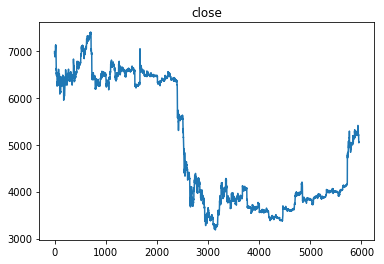

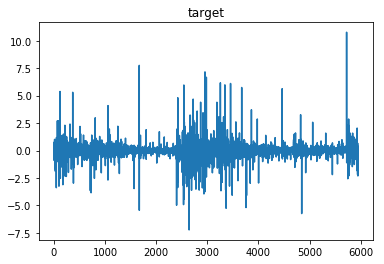

In [6]:
plt.figure(); plt.plot(arr[:, features.index('passthrough__close')]); plt.title('close')
plt.figure(); plt.plot(arr[:, features.index('make_target__close')]); plt.title('target')
# plt.figure(); plt.plot(df.filter(regex='v(t|f)')); plt.title('v(t|f)')
plt.show()

In [7]:
num_features = arr.shape[1] - pc['ty']
p('Number of Unique Features:', num_features)
p('Number of Hours per Sample:', pc['tx'])
p('Total Features per Sample:', pc['tx']*num_features)

Number of Unique Features: 18
Number of Hours per Sample: 72
Total Features per Sample: 1296


In [8]:
X, y = data_to_supervised(input_df=pd.DataFrame(data=arr, columns=ct.get_feature_names()), 
                                                target_ix=-1, Tx=pc['tx'], Ty=pc['ty'])
p(X.head(2))
p(y.head(5))

    var1(t-72)  var2(t-72)  var3(t-72)   var4(t-72)    var5(t-72)  \
72     6983.63     6948.10     6993.64  6960.886667  1.963340e+07   
73     6931.25     6924.72     6991.67  6958.693333  1.548184e+07   

     var6(t-72)   var7(t-72)    var8(t-72)  var9(t-72)  var10(t-72)  ...  \
72  2822.826667  6973.428333  1.651641e+07    2368.195  7009.180000  ...   
73  2219.570000  6963.413333  1.746497e+07    2505.475  6995.824167  ...   

     var10(t-1)    var11(t-1)   var12(t-1)   var13(t-1)    var14(t-1)  \
72  6352.301667  2.622451e+07  4119.527500  6331.336667  3.091387e+07   
73  6362.810000  2.813517e+07  4406.171667  6329.999583  3.184085e+07   

     var15(t-1)   var16(t-1)    var17(t-1)   var18(t-1)  var19(t-1)  
72  4882.572917  6510.597708  3.154096e+07  4849.238542    1.167292  
73  5024.923333  6496.710833  3.205902e+07  4932.590625   -0.872744  

[2 rows x 1368 columns]
     var1(t)
72 -0.872744
73  0.084648
74  0.400574
75 -0.010491
76 -0.012190


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=pc['test_fraction'], shuffle=False)
p('Train shape: ', X_train.shape)
p('Test shape: ', X_test.shape)

Train shape:  (5586, 1368)
Test shape:  (294, 1368)


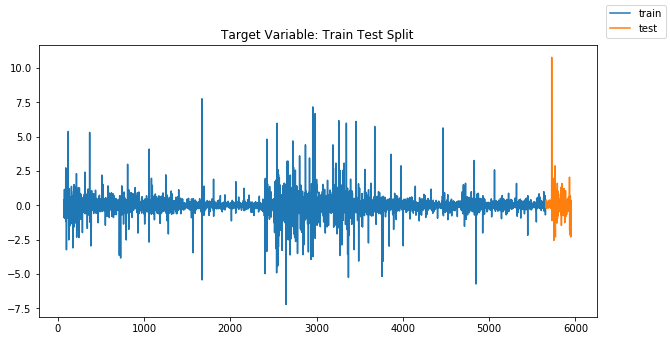

In [10]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(y_train, label='train')
ax.plot(y_test, label='test')
plt.title('Target Variable: Train Test Split')
fig.legend()
plt.show()